# GPU Interoperability using CuPy and Tensor Spline Interpolation

This notebook demonstrates GPU interoperability using CuPy and tensor spline interpolation. The following steps are performed:
1. Generates random data and coordinates.
2. Creates tensor splines using NumPy and CuPy.
3. Evaluates the splines on a set of coordinates.
4. Computes the absolute difference and mean square error between the NumPy and CuPy evaluations.
5. Plots the results.

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from splineops.interpolate.tensorspline import TensorSpline

## Data type

Need to provide floating numbers, "float64" and "float32" are typical.

In [2]:
dtype = "float32"

## Create random data samples and corresponding coordinates

In [3]:
nx, ny = 2, 5
xmin, xmax = -3.1, +1
ymin, ymax = 2, 6.5
xx = np.linspace(xmin, xmax, nx, dtype=dtype)
yy = np.linspace(ymin, ymax, ny, dtype=dtype)
coordinates = xx, yy
prng = np.random.default_rng(seed=5250)
data = prng.standard_normal(size=tuple(c.size for c in coordinates))
data = np.ascontiguousarray(data, dtype=dtype)

## Tensor spline bases and modes

Same basis applied to all dimensions and same mode applied to all dimensions.

In [4]:
bases = "bspline3"
modes = "mirror"

## Create tensor spline from NumPy data

In [5]:
data_np = data
coordinates_np = coordinates
tensor_spline_np = TensorSpline(
    data=data_np, coordinates=coordinates_np, bases=bases, modes=modes
)

## Create tensor spline from CuPy data for GPU computations

Note: We first need to convert the NumPy data to CuPy.

In [6]:
data_cp = cp.asarray(data)
coordinates_cp = cp.asarray(xx), cp.asarray(yy)
tensor_spline_cp = TensorSpline(
    data=data_cp, coordinates=coordinates_cp, bases=bases, modes=modes
)

CUDARuntimeError: cudaErrorInsufficientDriver: CUDA driver version is insufficient for CUDA runtime version

## Create evaluation coordinates (extended and oversampled in this case)

In [7]:
dx = (xx[-1] - xx[0]) / (nx - 1)
dy = (yy[-1] - yy[0]) / (ny - 1)
pad_fct = 1.1
px = pad_fct * nx * dx
py = pad_fct * ny * dy
eval_xx = np.linspace(xx[0] - px, xx[-1] + px, 100 * nx)
eval_yy = np.linspace(yy[0] - py, yy[-1] + py, 100 * ny)

## Evaluate using NumPy

In [8]:
eval_coords_np = eval_xx, eval_yy
data_eval_np = tensor_spline_np(coordinates=eval_coords_np)

## Evaluate using CuPy

Note: We first need to convert the evaluation coordinates to CuPy.

In [9]:
eval_coords_cp = cp.asarray(eval_xx), cp.asarray(eval_yy)
data_eval_cp = tensor_spline_cp(coordinates=eval_coords_cp)

CUDARuntimeError: cudaErrorInsufficientDriver: CUDA driver version is insufficient for CUDA runtime version

## Compute difference

In [10]:
abs_diff = np.abs(data_eval_cp.get() - data_eval_np)
mse = np.mean((data_eval_cp.get() - data_eval_np) ** 2)
print(f"Maximum absolute difference: {np.max(abs_diff)}")
print(f"Mean square error: {mse}")

NameError: name 'data_eval_cp' is not defined

## Plot results

NameError: name 'data_eval_cp' is not defined

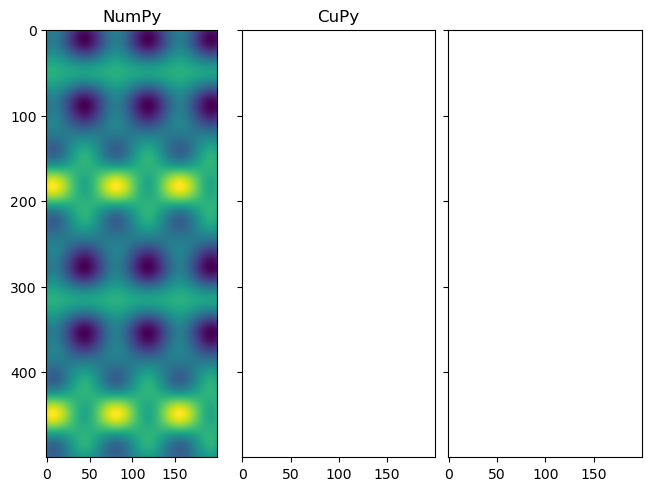

In [11]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, sharex="all", sharey="all", layout="constrained"
)
ax = axes[0]
ax.imshow(data_eval_np.T)
ax.set_title("NumPy")
ax = axes[1]
ax.set_title("CuPy")
ax.imshow(data_eval_cp.get().T)
ax = axes[2]
ax.set_title(f"Absolute difference\n(MSE: {mse:.2e})")
ax.imshow(abs_diff.T)

plt.show()